In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from os.path import join

plt.style.use(["seaborn", "thesis"])

/home/jcartus/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
subfolder = "EmbeddedBlocks/"

In [3]:
from SCFInitialGuess.utilities.usermessages import Messenger as msg

msg.print_level = 0

# Fetch Dataset 

In [4]:
from SCFInitialGuess.utilities.dataset import extract_triu_batch, AbstractDataset
from sklearn.model_selection import train_test_split
from pyscf.scf import hf

data_path = "../../../dataset/EthenT/"
postfix = "EthenT"
dim = 72
N_ELECTRONS = 16
basis = "6-311++g**"
subfolder = "EmbeddedBlocks/"
#data_path = "../../../cc2ai/ethen/"
#postfix = "_ethen_6-31g**"
#dim = 48
#N_ELECTRONS = 16
#basis = "6-31g**"
#data_path = "../../dataset/TSmall_sto3g"
#postfix = "TSmall_sto3g"
#dim = 26
#N_ELECTRONS = 30
#basis = "sto-3g"
#data_path = "../../../butadien/data/"
#postfix = ""
#dim = 26


def split(x, y, ind):
    return x[:ind], y[:ind], x[ind:], y[ind:]

#S, P = np.load(join(data_path, "dataset" + postfix + ".npy"))
S = np.load(join(data_path, "S" + postfix + ".npy"))
P = np.load(join(data_path, "P" + postfix + ".npy"))

#index = np.load(join(data_path, "index" + postfix + ".npy"))


ind = 0#int(0.8 * len(S))

molecules = np.load(join(data_path, "molecules" + postfix + ".npy"))
molecules = (molecules[:ind], molecules[ind:])



h_test = [hf.get_hcore(mol.get_pyscf_molecule()) for mol in molecules[1]]

s_triu_norm, mu, std = AbstractDataset.normalize(S)

s_train, p_train, s_test, p_test = split(S.reshape(-1, dim, dim), P.reshape(-1, dim, dim), ind)
#s_test, p_test = S.reshape(-1, dim, dim), P.reshape(-1, dim, dim)

# Utilities 

In [5]:
def fock_from_density_batch(p_batch):
    f = []
    for p, s, h, mol in zip(p_batch, s_test, h_test, molecules[1]):
        f.append(hf.get_fock(None, h1e=h, s1e=s, vhf=hf.get_veff(mol=mol.get_pyscf_molecule(), dm=p), dm=p))
    return np.array(f)

In [6]:
f_test = fock_from_density_batch(p_test)
np.save(data_path + subfolder + "f_test.npy", f_test)

In [7]:
from pyscf.scf import hf

def density_from_fock(f, s, mol):
    
    mo_energy, mo_coeff = hf.eig(f, s)
    mo_occ = hf.get_occ(mf=hf.SCF(mol), mo_energy=mo_energy, mo_coeff=mo_coeff)
    
    return hf.make_rdm1(mo_coeff, mo_occ)

def density_from_fock_batch(f_batch):
    p = []
    for (s, f, mol) in zip(s_test, f_batch, molecules[1]):
        p.append(density_from_fock(f, s, mol.get_pyscf_molecule()))
    return np.array(p)

In [8]:
from SCFInitialGuess.utilities.analysis import make_results_str, measure_all_quantities
from SCFInitialGuess.utilities.dataset import StaticDataset

dataset = StaticDataset(
    train=(s_train, p_train),
    validation=(None, None),
    test=(s_test, p_test),
    mu=mu,
    std=std
)

In [9]:
f_test.shape

(1001, 72, 72)

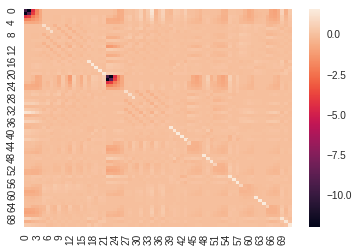

In [10]:
import seaborn as sns

sns.heatmap(f_test[0].reshape(dim, dim))

In [11]:
p_test_test = density_from_fock_batch(f_test)

In [12]:
np.mean(np.abs(p_test.flatten() - p_test_test.flatten()))

3.920578299795889e-08

In [13]:
from SCFInitialGuess.utilities.analysis import mf_initializer, make_results_str, measure_all_quantities



print(make_results_str(measure_all_quantities(
    p_test_test,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

--- Absolute Error ---
3.92058E-08 +- 4.90271E-08
--- Symmetry Error ---
0.00000E+00 +- 0.00000E+00
--- Idempotence Error ---
3.11507E-17 +- 7.12530E-18
--- Occupance Error ---
5.27938E-15 +- 4.27929E-15
--- HF Energy Error ---
9.42730E-12 +- 1.23637E-11
--- Avg. Iterations ---
1.00000E+00 +- 0.00000E+00
--- Avg. Iterations W/O Non Converged ---
1.00000E+00 +- 0.00000E+00
--- Num. Not Convd. ---
0



# Pure blocks

i will now set all other elements zero

## Utilities

In [14]:
from SCFInitialGuess.utilities.analysis import mf_initializer_damping as mf_initializer_standard

def mf_initializer(mol):
    mf = mf_initializer_standard(mol)
    mf.max_cycle = 100
    return mf

In [16]:
from SCFInitialGuess.utilities.constants import number_of_basis_functions as N_BASIS

mol = molecules[1][0]

mask = np.zeros((dim, dim))

current_dim = 0
for atom in mol.species:
    
    # calculate block range
    index_start = current_dim
    current_dim += N_BASIS[basis][atom] 
    index_end = current_dim
    
    # calculate logical vector
    L = np.arange(dim)
    L = np.logical_and(index_start <= L, L < index_end)
    
    m = np.logical_and.outer(L, L)
    mask = np.logical_or(mask, m)
    
#mask

In [17]:
from SCFInitialGuess.utilities.dataset import reconstruct_from_triu

def extract_pure(p):
    p_batch = p.copy()
    p_batch[np.logical_not(mask)] = 0
    return p_batch

f_pure = np.array(list(map(extract_pure, f_test))).astype("float64")

In [18]:
np.save(data_path + subfolder + "f_pure.npy", f_pure)

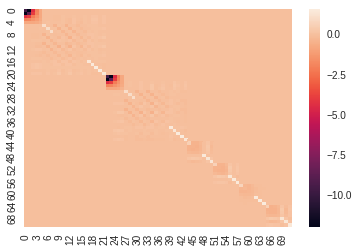

In [19]:
sns.heatmap(f_pure[0])

## Pure Block Analysis 

In [20]:


print(make_results_str(measure_all_quantities(
    density_from_fock_batch(f_pure),
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

--- Absolute Error ---
1.58759E+01 +- 5.92054E+01
--- Symmetry Error ---
0.00000E+00 +- 0.00000E+00
--- Idempotence Error ---
3.02343E-11 +- 6.50444E-11
--- Occupance Error ---
1.91066E-12 +- 2.46154E-12
--- HF Energy Error ---
3.06065E+01 +- 8.19006E+00
--- Avg. Iterations ---
9.99421E+01 +- 1.83229E+00
--- Avg. Iterations W/O Non Converged ---
1.00000E+02 +- 0.00000E+00
--- Num. Not Convd. ---
1000



# Embedding the Blocks In Classical Guesses

In [21]:
from SCFInitialGuess.utilities.dataset import reconstruct_from_triu

def embedd(x, y):
    p = x.copy()
    p[mask] = (y.copy())[mask]
    return p

def embedd_batch(f_batch):
    f_embedded = []
    for (f_guess, f_conv) in zip(f_batch, f_test):
        f_embedded.append(embedd(f_guess, f_conv))
    return np.array(f_embedded)


## Converged in Converged 

In [22]:
f_test_test_test = embedd_batch(f_test)

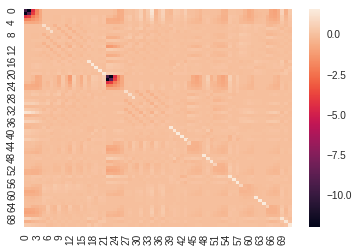

In [23]:
sns.heatmap(f_test_test_test[0])

In [24]:

print(make_results_str(measure_all_quantities(
    density_from_fock_batch(f_test_test_test),
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

--- Absolute Error ---
3.92058E-08 +- 4.90271E-08
--- Symmetry Error ---
0.00000E+00 +- 0.00000E+00
--- Idempotence Error ---
3.11507E-17 +- 7.12530E-18
--- Occupance Error ---
5.27938E-15 +- 4.27929E-15
--- HF Energy Error ---
9.42651E-12 +- 1.23640E-11
--- Avg. Iterations ---
1.00000E+00 +- 0.00000E+00
--- Avg. Iterations W/O Non Converged ---
1.00000E+00 +- 0.00000E+00
--- Num. Not Convd. ---
0



## Zeros 

In [25]:
f_test_zeros = embedd_batch(np.zeros(f_test.shape))

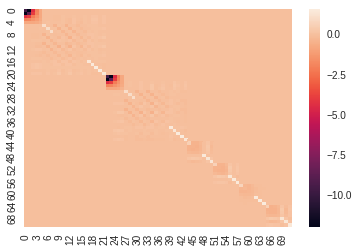

In [26]:
sns.heatmap(f_test_zeros[0])

In [27]:
print(make_results_str(measure_all_quantities(
    density_from_fock_batch(f_test_zeros),
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

--- Absolute Error ---
1.58759E+01 +- 5.92054E+01
--- Symmetry Error ---
0.00000E+00 +- 0.00000E+00
--- Idempotence Error ---
3.02343E-11 +- 6.50444E-11
--- Occupance Error ---
1.91066E-12 +- 2.46154E-12
--- HF Energy Error ---
3.06065E+01 +- 8.19006E+00
--- Avg. Iterations ---
9.99421E+01 +- 1.83229E+00
--- Avg. Iterations W/O Non Converged ---
1.00000E+02 +- 0.00000E+00
--- Num. Not Convd. ---
1000



# GWH

In [28]:
f_gwh = []

k = np.ones((dim, dim)) * 1.75 - \
            np.diag(np.ones(dim)) * 0.75  

for h,s in zip(h_test, s_test):
    h_diag = np.diag(h)   
        
    f_gwh.append(k * np.add.outer(h_diag, h_diag) * s / 2)
    
f_gwh = np.array(f_gwh)

In [29]:
np.save(data_path + subfolder + "f_gwh.npy", f_gwh)

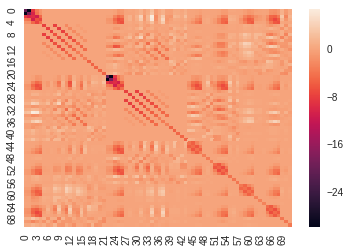

In [30]:
sns.heatmap(f_gwh[0])

In [31]:
print(make_results_str(measure_all_quantities(
    density_from_fock_batch(f_gwh),
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

--- Absolute Error ---
1.44548E-02 +- 1.09225E-02
--- Symmetry Error ---
0.00000E+00 +- 0.00000E+00
--- Idempotence Error ---
2.84630E-17 +- 5.36726E-18
--- Occupance Error ---
4.89607E-15 +- 4.09765E-15
--- HF Energy Error ---
4.90516E+00 +- 4.94588E-01
--- Avg. Iterations ---
9.78162E+01 +- 1.18032E+01
--- Avg. Iterations W/O Non Converged ---
1.00000E+02 +- 0.00000E+00
--- Num. Not Convd. ---
967



## EmbeddedGWH 

In [32]:
f_embedded_gwh = embedd_batch(f_gwh)

In [33]:
np.save(data_path + subfolder + "f_embedded_gwh.npy", f_embedded_gwh)

### Diff Conv vs GWH 

In [34]:
np.mean(np.abs(f_test.flatten() - f_gwh.flatten()))

0.8007077155630588

### Diff Embedded vs gwh

In [35]:
np.mean(np.abs(f_embedded_gwh.flatten() - f_gwh.flatten()))

0.22473747438468838

### Diff Conv vs Embedded 

In [36]:
np.mean(np.abs(f_embedded_gwh.flatten() - f_test.flatten()))

0.5759702411783706

### Analysing the density

In [37]:
p_embedded_gwh = density_from_fock_batch(f_embedded_gwh)

In [38]:
print(make_results_str(measure_all_quantities(
    p_embedded_gwh,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

--- Absolute Error ---
4.56640E-02 +- 3.91440E-02
--- Symmetry Error ---
0.00000E+00 +- 0.00000E+00
--- Idempotence Error ---
8.86602E-17 +- 2.06474E-17
--- Occupance Error ---
4.73281E-15 +- 3.80349E-15
--- HF Energy Error ---
4.40846E+00 +- 3.32923E-01
--- Avg. Iterations ---
4.56543E+01 +- 3.23045E+01
--- Avg. Iterations W/O Non Converged ---
3.20000E+01 +- 0.00000E+00
--- Num. Not Convd. ---
254



In [63]:
254 / len(molecules[1])

0.25374625374625376

## SAD

In [39]:
f_sad = fock_from_density_batch(np.array([
    hf.init_guess_by_atom(mol.get_pyscf_molecule()) for mol in molecules[1]
]))

In [40]:
np.save(data_path + subfolder + "f_sad.npy", f_sad)

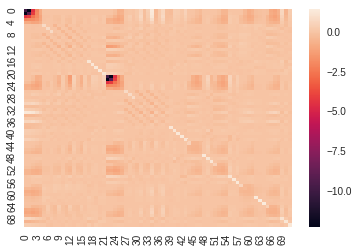

In [41]:
sns.heatmap(f_sad[0])

In [42]:
print(make_results_str(measure_all_quantities(
    density_from_fock_batch(f_sad),
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

--- Absolute Error ---
3.99305E-03 +- 3.84032E-03
--- Symmetry Error ---
0.00000E+00 +- 0.00000E+00
--- Idempotence Error ---
3.04059E-17 +- 6.33197E-18
--- Occupance Error ---
5.03449E-15 +- 4.20920E-15
--- HF Energy Error ---
7.31085E-02 +- 1.56547E-02
--- Avg. Iterations ---
2.43996E+01 +- 8.23834E+00
--- Avg. Iterations W/O Non Converged ---
3.40000E+01 +- 0.00000E+00
--- Num. Not Convd. ---
0



## Embedded SAD

In [43]:
f_embedded_sad = embedd_batch(f_sad)

In [44]:
np.save(data_path + subfolder + "f_embedded_sad.npy", f_embedded_sad)

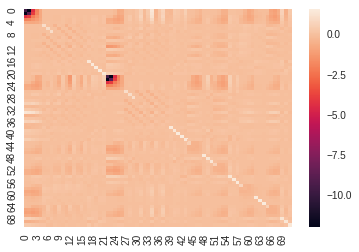

In [45]:
sns.heatmap(f_embedded_sad[0])

In [46]:
p_embedded_sad = density_from_fock_batch(f_embedded_sad)

In [47]:
print(make_results_str(measure_all_quantities(
    p_embedded_sad,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

--- Absolute Error ---
1.82383E-02 +- 1.67489E-02
--- Symmetry Error ---
0.00000E+00 +- 0.00000E+00
--- Idempotence Error ---
4.80212E-17 +- 1.11483E-17
--- Occupance Error ---
4.90495E-15 +- 4.01740E-15
--- HF Energy Error ---
9.71111E-02 +- 1.18776E-02
--- Avg. Iterations ---
2.19091E+01 +- 6.64023E+00
--- Avg. Iterations W/O Non Converged ---
3.20000E+01 +- 0.00000E+00
--- Num. Not Convd. ---
0



# McWheeny Density

In [48]:
from SCFInitialGuess.utilities.dataset import make_matrix_batch
s_test_batch = make_matrix_batch(S[ind:], dim)

In [49]:
from SCFInitialGuess.nn.post_processing import multi_mc_wheeny

def multi_mc_wheeny_batch(p_batch):
    p_res = []
    for p, s in zip(p_batch, s_test_batch):
        p_res.append(multi_mc_wheeny(p, s, 5))
    return np.asarray(p_res)

### GWH

In [50]:
p_embedded_gwh_mcw5 = multi_mc_wheeny_batch(p_embedded_gwh)

In [51]:
from SCFInitialGuess.utilities.analysis import mf_initializer

print(make_results_str(measure_all_quantities(
    p_embedded_gwh_mcw5,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

--- Absolute Error ---
4.56640E-02 +- 3.91440E-02
--- Symmetry Error ---
1.08690E-16 +- 1.22751E-17
--- Idempotence Error ---
6.98358E-17 +- 7.00719E-18
--- Occupance Error ---
1.64859E-15 +- 1.97135E-15
--- HF Energy Error ---
4.40846E+00 +- 3.32923E-01
--- Avg. Iterations ---
5.47073E+01 +- 3.12755E+01
--- Avg. Iterations W/O Non Converged ---
3.20000E+01 +- 0.00000E+00
--- Num. Not Convd. ---
280



In [66]:
280/1001

0.27972027972027974

### SAP 

In [52]:
p_embedded_sap_mcw5 = multi_mc_wheeny_batch(p_embedded_sad)

In [53]:
from SCFInitialGuess.utilities.analysis import mf_initializer

print(make_results_str(measure_all_quantities(
    p_embedded_sap_mcw5,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

--- Absolute Error ---
1.82383E-02 +- 1.67489E-02
--- Symmetry Error ---
4.75902E-17 +- 1.20647E-17
--- Idempotence Error ---
3.04880E-17 +- 7.48796E-18
--- Occupance Error ---
7.71943E-16 +- 1.31188E-15
--- HF Energy Error ---
9.71111E-02 +- 1.18776E-02
--- Avg. Iterations ---
2.85255E+01 +- 1.94496E+01
--- Avg. Iterations W/O Non Converged ---
2.50000E+01 +- 0.00000E+00
--- Num. Not Convd. ---
42



In [67]:
45/1001

0.04495504495504495

# McWheeny Fock 

In [54]:
from SCFInitialGuess.nn.post_processing import multi_mc_wheeny

def multi_mc_wheeny_batch_fock(p_batch):
    p_res = []
    for p, s in zip(p_batch, s_test_batch):
        p_res.append(multi_mc_wheeny(p, s, 1))
    return np.asarray(p_res)

## GWH 

In [55]:
f_gwh_mcw5 = multi_mc_wheeny_batch_fock(f_gwh)

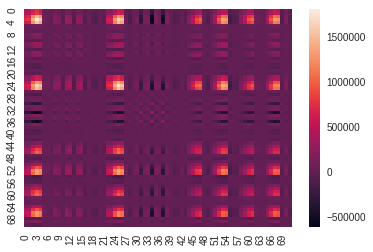

In [56]:
sns.heatmap(f_gwh_mcw5[0])

# Embedd Outer 

In [57]:
from SCFInitialGuess.utilities.dataset import reconstruct_from_triu

def embedd_outer(x, y):
    p = x.copy()
    p[np.logical_not(mask)] = (y.copy())[np.logical_not(mask)]
    return p

def embedd_batch_outer(f_batch):
    f_embedded = []
    for (f_guess, f_conv) in zip(f_batch, f_test):
        f_embedded.append(embedd_outer(f_guess, f_conv))
    return np.array(f_embedded)

## Converged 

In [58]:
print(make_results_str(measure_all_quantities(
    density_from_fock_batch(embedd_batch_outer(f_embedded_sad)),
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

--- Absolute Error ---
3.92058E-08 +- 4.90271E-08
--- Symmetry Error ---
0.00000E+00 +- 0.00000E+00
--- Idempotence Error ---
3.11507E-17 +- 7.12530E-18
--- Occupance Error ---
5.27938E-15 +- 4.27929E-15
--- HF Energy Error ---
9.42579E-12 +- 1.23649E-11
--- Avg. Iterations ---
1.00000E+00 +- 0.00000E+00
--- Avg. Iterations W/O Non Converged ---
1.00000E+00 +- 0.00000E+00
--- Num. Not Convd. ---
0



## SAD 

In [59]:
f_embedded_outer_sad = embedd_batch_outer(f_sad)

In [60]:
print(make_results_str(measure_all_quantities(
    density_from_fock_batch(f_embedded_outer_sad),
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

--- Absolute Error ---
1.65497E+01 +- 6.09536E+01
--- Symmetry Error ---
0.00000E+00 +- 0.00000E+00
--- Idempotence Error ---
3.06999E-11 +- 6.24406E-11
--- Occupance Error ---
1.95724E-12 +- 2.24435E-12
--- HF Energy Error ---
2.25980E+01 +- 6.76589E+00
--- Avg. Iterations ---
9.62877E+01 +- 1.41617E+01
--- Avg. Iterations W/O Non Converged ---
1.00000E+02 +- 0.00000E+00
--- Num. Not Convd. ---
934



In [68]:
934/1001

0.9330669330669331

## GWH 

In [61]:
f_embedded_outer_gwh = embedd_batch_outer(f_gwh)

In [62]:
print(make_results_str(measure_all_quantities(
    density_from_fock_batch(f_embedded_outer_gwh),
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

--- Absolute Error ---
1.36715E+01 +- 5.25182E+01
--- Symmetry Error ---
0.00000E+00 +- 0.00000E+00
--- Idempotence Error ---
2.35618E-11 +- 5.10605E-11
--- Occupance Error ---
1.87476E-12 +- 2.22407E-12
--- HF Energy Error ---
8.70841E+01 +- 6.34133E+00
--- Avg. Iterations ---
9.80549E+01 +- 1.00477E+01
--- Avg. Iterations W/O Non Converged ---
1.00000E+02 +- 0.00000E+00
--- Num. Not Convd. ---
960



In [69]:
960 / 1001

0.9590409590409591